# Pointwise Reliability: Density, Clustering - Subtractive

## Workflow:
- Perform a grid search over `cluster_influence_range`
  - Select the parameters that maximize the number of clusters
  - Where there is no cluster with less than `min_members_per_cluster` members
- Train
  - Use the best `cluster_influence_range` parameter to train the final subtractive clustering model
  - Assign all training data points to clusters using the influence_range
- Workflow Reliability:
  - Identify the nearest cluster center and check if the distance is within the `cluster_influence_range`
    - If within range, the instance is considered part of the cluster; otherwise, it is outside all clusters.
  - Identifies which cluster the new instance would belong to based on its nearest core point.
  - Calculates the size of the identified cluster 
  - Compute reliability:
    - reliability =  cluster_size / `minimum_cluster_units`
      - `minimum_cluster_units` <- param 
      - If the cluster size is larger than the threshold (minimum cluster units): reliability = 1
      - If the new instance is not part of any cluster: reliability = 0

In [1]:
import joblib
import pandas as pd
import numpy as np
from utils.subtractive_clustering import SubtractiveClustering
from sklearn.neighbors import NearestNeighbors
from utils.reliability_visualizer import ReliabilityVisualizer

###########################################################
# Load Classifier and Training Data
###########################################################
pipeline = joblib.load('pipeline_classifier.pkl')
training_data = pd.read_csv("./data_train.csv")

y_train = training_data['SOURCE'].map({'out': 0, 'in': 1})
X_train = training_data.drop(columns=['SOURCE'])

X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

In [2]:
###########################################################
# Subtractive Clustering - Grid Search
###########################################################

cluster_influence_ranges = np.linspace(0.05, 0.5, 20)
min_members_per_cluster = 3  # Minimum members required in every cluster

results = []
for influence_range in cluster_influence_ranges:
    clustering = SubtractiveClustering(cluster_influence_range=influence_range)
    cluster_centers = clustering.fit(X_train_preprocessed)
    
    # Assign points to clusters (assignment_radius -> threshold = ra/2)
    threshold = ( influence_range / 2 ) # (using influence radius ra/2)
    cluster_members = {}
    for i, point in enumerate(X_train_preprocessed):
        distances_to_centers = np.linalg.norm(cluster_centers - point, axis=1)
        closest_cluster = np.argmin(distances_to_centers)
        if distances_to_centers[closest_cluster] <= threshold: # (using influence radius ra/2)
            if closest_cluster not in cluster_members:
                cluster_members[closest_cluster] = []
            cluster_members[closest_cluster].append(i)

    # Validate the clustering configuration
    valid_clusters = True
    for cluster_idx, members in cluster_members.items():
        if len(members) < min_members_per_cluster:
            valid_clusters = False
            break  # No need to check further, this configuration is invalid

    if valid_clusters:
        n_clusters = len(cluster_members)
        max_samples = max(len(members) for members in cluster_members.values()) if n_clusters > 0 else 0
        results.append({
            "influence_range": influence_range,
            "n_clusters": n_clusters,
            "max_samples": max_samples
        })

results_df = pd.DataFrame(results)

# Find the influence range that maximizes the number of clusters
if not results_df.empty:
    best_params = results_df.loc[results_df['n_clusters'].idxmax()]
    best_influence_range = best_params['influence_range']
    best_max_samples = best_params['max_samples']

    print("Best Parameters to Maximize Valid Clusters:")
    print(f"Influence Range: {best_influence_range}")
    print(f"Max Samples in a Cluster: {best_max_samples}")

Best Parameters to Maximize Valid Clusters:
Influence Range: 0.16842105263157897
Max Samples in a Cluster: 22.0


In [3]:
###########################################################
# Train
###########################################################

##################################
###### TODO: Ajdust
# my_cluster_influence_range=0.2
my_cluster_influence_range=best_influence_range # Influence range for assigning points to clusters
threshold = (my_cluster_influence_range  /2) # Influence range for assigning points to clusters (using influence radius ra/2)

clustering = SubtractiveClustering(cluster_influence_range=my_cluster_influence_range)
cluster_centers = clustering.fit(X_train_preprocessed)

cluster_members = {}
for i, point in enumerate(X_train_preprocessed):
    distances_to_centers = np.linalg.norm(cluster_centers - point, axis=1)
    closest_cluster = np.argmin(distances_to_centers)
    if distances_to_centers[closest_cluster] <= ( my_cluster_influence_range / 2): 
        if closest_cluster not in cluster_members:
            cluster_members[closest_cluster] = []
        cluster_members[closest_cluster].append(i)

In [4]:
###########################################################
# Reliability Calculation
###########################################################

def calculate_reliability_with_subtractive(new_instance, cluster_centers, cluster_members, threshold, min_cluster_units):
    """
    Calculate reliability of a new instance based on subtractive clustering.

    Parameters:
    - new_instance: Preprocessed new instance.
    - cluster_centers: Identified cluster centers.
    - cluster_members: Members of each cluster.
    - threshold (float): Distance threshold for cluster membership.
    - min_cluster_units (int): Minimum number of points required for full reliability.

    Returns:
    - reliability_score: Reliability score based on cluster size.
    - in_cluster: Boolean indicating if the instance is part of a cluster.
    """
    # Find the nearest cluster center
    distances = np.linalg.norm(cluster_centers - new_instance, axis=1)
    closest_cluster = np.argmin(distances)

    # Check if within threshold
    if distances[closest_cluster] <= threshold:
        cluster_size = len(cluster_members[closest_cluster])
        reliability_score = min(cluster_size / min_cluster_units, 1.0)
        return reliability_score, True
    else:
        return 0, False

def classify_and_check_reliability_subtractive(new_data, pipeline, cluster_centers, cluster_members, threshold, min_cluster_units):
    """
    Predicts the class, determines cluster membership, and calculates reliability.

    Parameters:
    - new_data (pd.DataFrame): DataFrame with the same columns as training data.
    - pipeline (Pipeline): The loaded pipeline for preprocessing and classification.
    - cluster_centers: Identified cluster centers.
    - cluster_members: Members of each cluster.
    - threshold (float): Distance threshold for cluster membership.
    - min_cluster_units (int): Minimum number of points required for full reliability.

    Returns:
    - dict: Contains prediction, cluster membership, and reliability score.
    """
    new_data_preprocessed = pipeline.named_steps['preprocessor'].transform(new_data)

    predicted_label = pipeline.named_steps['classifier'].predict(new_data_preprocessed)[0]

    reliability_score, in_cluster = calculate_reliability_with_subtractive(
        new_data_preprocessed[0], cluster_centers, cluster_members, threshold, min_cluster_units
    )

    return {
        "predicted_label": predicted_label,
        "reliability_score": reliability_score,
        "in_cluster": in_cluster
    }

In [5]:
###########################################################
# Load Validation Data and Test
###########################################################
validation_data = pd.read_csv("./data_validation.csv")
validation_data['SOURCE'] = validation_data['SOURCE'].map({'out': 0, 'in': 1})
results = []

###############
### TODO: Adjust
min_cluster_units = 9  # Minimum points for full reliability

for _, instance in validation_data.iterrows():
    true_label = instance['SOURCE']
    instance_df = pd.DataFrame([instance.drop(labels=['SOURCE'])])
    result = classify_and_check_reliability_subtractive(
        instance_df, pipeline, cluster_centers, cluster_members, threshold, min_cluster_units
    )
    result['true_label'] = true_label
    results.append(result)

# Filter results where reliability_score > 0
filtered_results = [result for result in results if result['reliability_score'] > 0]

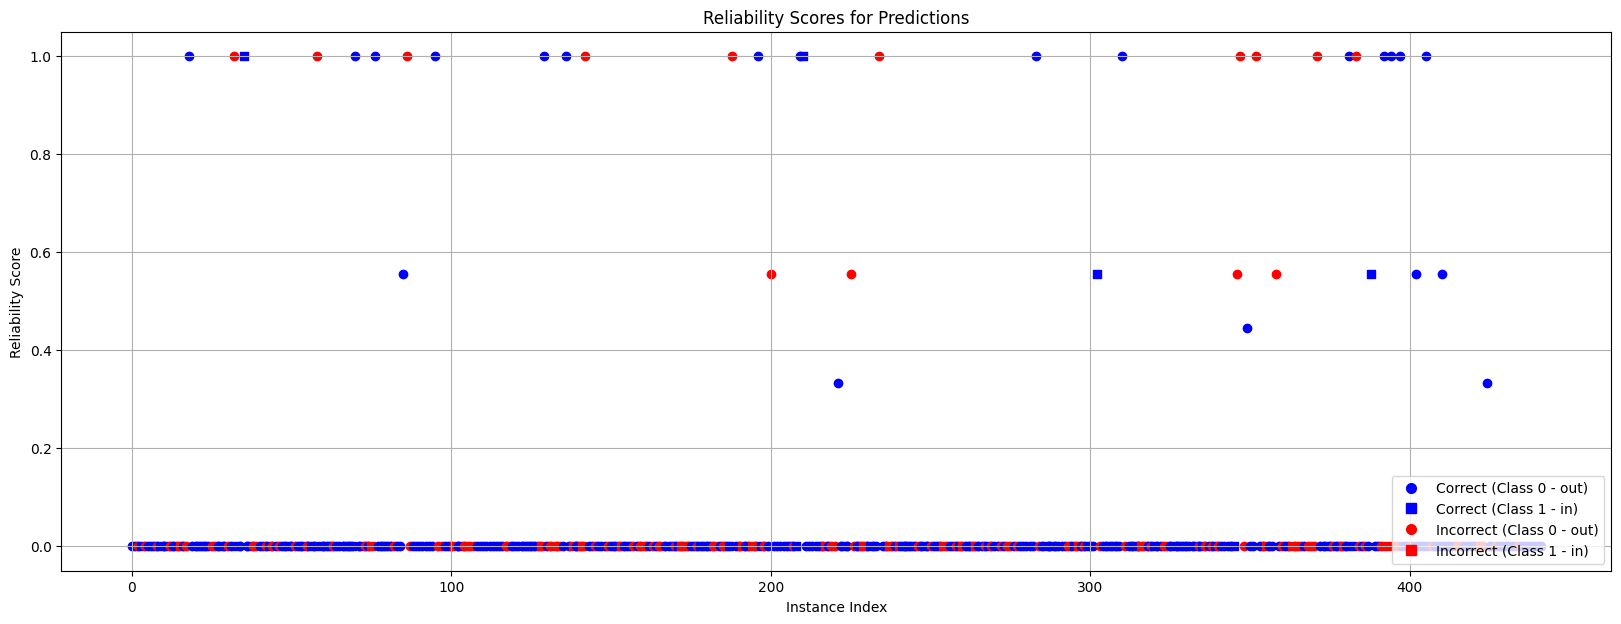

In [6]:
###########################################################
# Results and Visualization
###########################################################
results_df = pd.DataFrame(results)

visualizer = ReliabilityVisualizer(results_df=results_df)
visualizer.plot_reliability_scores((20, 7))

### 10

In [7]:
reliability_table_10_df = visualizer.get_reliability_table_10()
print(reliability_table_10_df)

    Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0  [0.00, 0.10]          209             92           69             33
1  ]0.10, 0.20]            0              0            0              0
2  ]0.20, 0.30]            0              0            0              0
3  ]0.30, 0.40]            2              0            0              0
4  ]0.40, 0.50]            1              0            0              0
5  ]0.50, 0.60]            3              4            2              0
6  ]0.60, 0.70]            0              0            0              0
7  ]0.70, 0.80]            0              0            0              0
8  ]0.80, 0.90]            0              0            0              0
9  ]0.90, 1.00]           15             10            2              0


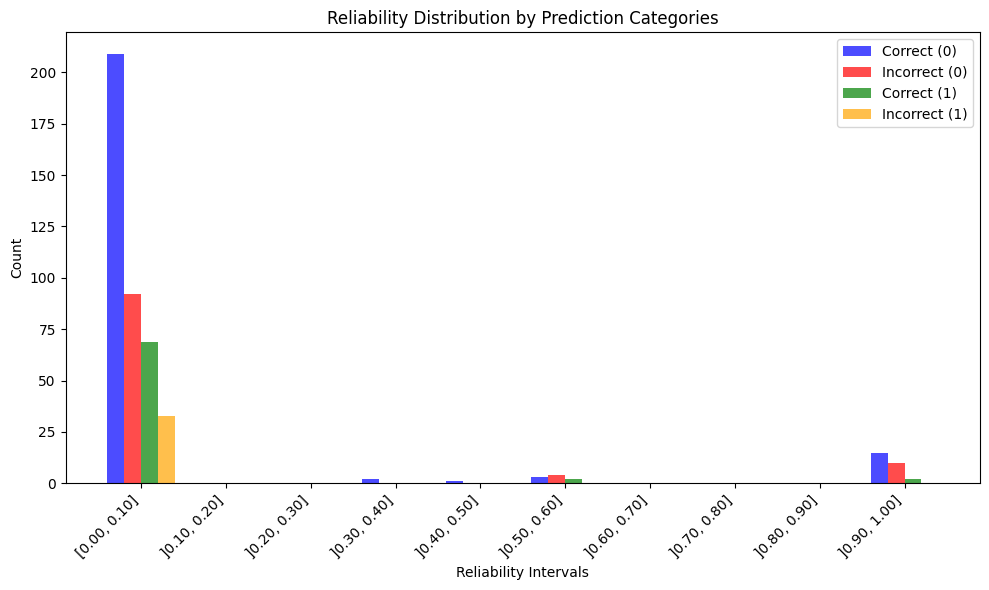

In [8]:
visualizer.plot_table_graph(reliability_table_10_df)

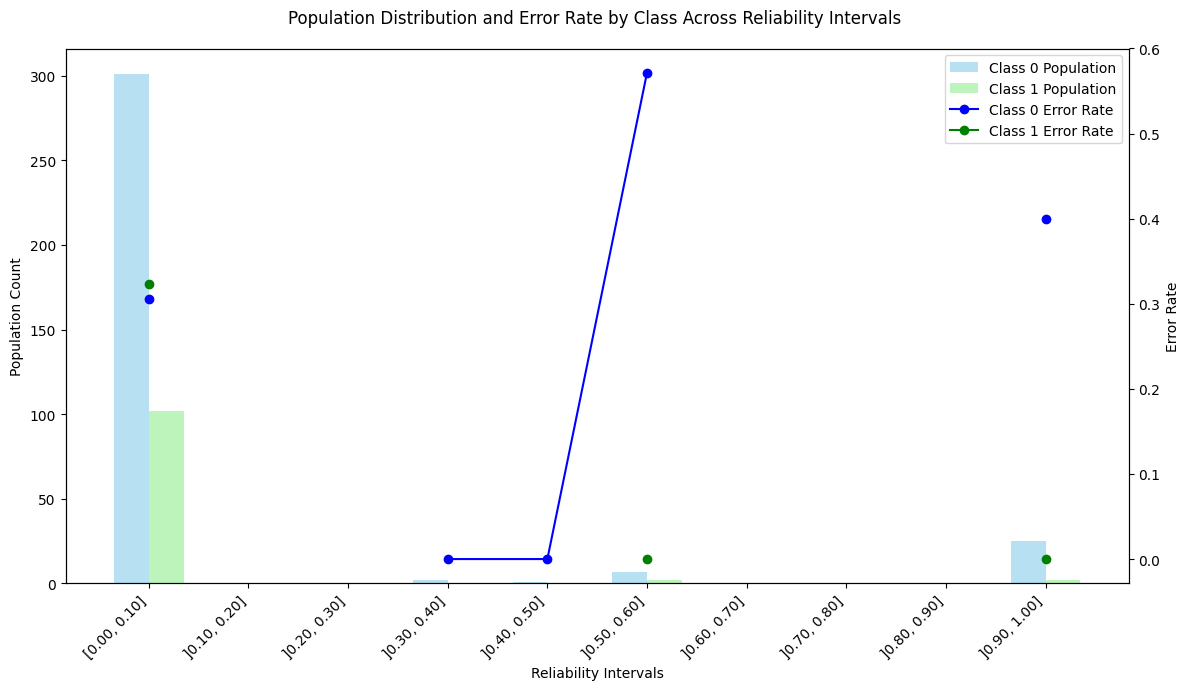

In [9]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_10_df)